# Flow  
## 1. Read&Merge train,test files  
## 2. Drop columns from missing value threshold  
## 3. Split types (numeric , object)  
## 4. Fill fake NA  
## 5. Impute actual NA  
## 6. Scale shift (numeric)  
## 7. Scale shift (object)  
## 8. Split data (train , test)  
## 9. Create model & optimize parameters  
## 10. Make submit file & visualize model performance

### 1. Read&Merge train,test files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
filepath='D:/downloads/house-prices-advanced-regression-techniques/'
train = pd.read_csv(filepath+'train.csv')
test = pd.read_csv(filepath+'test.csv')
split_point = train.shape[0]
data = train.drop('SalePrice',axis=1).append(test,ignore_index=True)

In [3]:
data.isnull().sum()[data.isnull().sum()>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

### 2. Threshold : 100 (more than 100 missing NA values) 

In [4]:
threshold = 100
drop_cols = data.isnull().sum()[data.isnull().sum()>threshold].index.values
drop_cols

array(['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'], dtype=object)

drop colunms above threshold + useless column (Id)

In [5]:
data = data.drop(drop_cols,axis=1)
data = data.drop('Id',axis=1)

### 3. Split types : numeric , object

In [6]:
object_cols = data.columns[data.columns.map(lambda x : data[x].dtype) == 'object']
numeric_cols = data.columns[data.columns.map(lambda x : data[x].dtype) != 'object']

numeric type columns with na values

In [7]:
data[numeric_cols].isnull().sum()[data[numeric_cols].isnull().sum()>0]

MasVnrArea      23
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
GarageCars       1
GarageArea       1
dtype: int64

object type columns with na values

In [8]:
data[object_cols].isnull().sum()[data[object_cols].isnull().sum()>0]

MSZoning         4
Utilities        2
Exterior1st      1
Exterior2nd      1
MasVnrType      24
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
Electrical       1
KitchenQual      1
Functional       2
SaleType         1
dtype: int64

### 4. Fill fake na values with relative groups (where nan actually means something)  
1. __`group 1`__  
    - MasVnrArea , MasVnrType  
2. __`group 2`__  
    - BsmtFinSF1 , BsmtFinSF2 , BsmtUnfSF , TotalBsmtSF , BsmtQual , BsmtCond , BsmtExposure , BsmtFinType1 , BsmtFinType2  
3. __`group 3`__  
    - Exterior1st , Exterior2nd  

__`group 1` : MasVnrArea , MasVnrType__

In [9]:
group1 = ['MasVnrArea','MasVnrType']

incorrect MasVnrType to 'None'

In [10]:
print(data[group1][(data.MasVnrArea==0) & (data.MasVnrType!='None')])
idx = data[(data.MasVnrArea==0) & (data.MasVnrType!='None')].index.values
data.loc[idx,'MasVnrType'] = 'None'

      MasVnrArea MasVnrType
688          0.0    BrkFace
1241         0.0      Stone
2319         0.0    BrkFace


incorrect MasVnrArea to '0.0'

In [11]:
print(data[group1][(data.MasVnrArea!=0) & (data.MasVnrType=='None')])
idx = data[(data.MasVnrArea!=0) & (data.MasVnrType=='None')].index.values
data.loc[idx,'MasVnrArea'] = 0

      MasVnrArea MasVnrType
624        288.0       None
773          1.0       None
1230         1.0       None
1300       344.0       None
1334       312.0       None
1669       285.0       None
2452         1.0       None


fill common nan row with {'MasVnrType':'None' , 'MasVnrArea':0}

In [12]:
print(data[group1][(data.MasVnrArea.isnull()) & (data.MasVnrType.isnull())])
idx = data[(data.MasVnrArea.isnull()) & (data.MasVnrType.isnull())].index.values
data.loc[idx,'MasVnrArea'] = 0
data.loc[idx,'MasVnrType'] = 'None'

      MasVnrArea MasVnrType
234          NaN        NaN
529          NaN        NaN
650          NaN        NaN
936          NaN        NaN
973          NaN        NaN
977          NaN        NaN
1243         NaN        NaN
1278         NaN        NaN
1691         NaN        NaN
1706         NaN        NaN
1882         NaN        NaN
1992         NaN        NaN
2004         NaN        NaN
2041         NaN        NaN
2311         NaN        NaN
2325         NaN        NaN
2340         NaN        NaN
2349         NaN        NaN
2368         NaN        NaN
2592         NaN        NaN
2657         NaN        NaN
2686         NaN        NaN
2862         NaN        NaN


Remaining actual na values

In [13]:
data[group1].isnull().sum()

MasVnrArea    0
MasVnrType    1
dtype: int64

__`group 2` : BsmtFinSF1 , BsmtFinSF2 , BsmtUnfSF , TotalBsmtSF , BsmtQual , BsmtCond , BsmtExposure , BsmtFinType1 , BsmtFinType2__  

In [14]:
group2 = ['BsmtFinSF1' , 'BsmtFinSF2' , 'BsmtUnfSF' , 'TotalBsmtSF' ,
          'BsmtQual' , 'BsmtCond' , 'BsmtExposure' , 'BsmtFinType1' , 'BsmtFinType2']

common object type rows with na values ==> 79

In [15]:
data[['BsmtQual' , 'BsmtCond' , 'BsmtExposure' , 'BsmtFinType1' , 'BsmtFinType2']].isnull().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64

check if other columns have na values as well ==> okay

In [16]:
idx = data[data.BsmtFinType1.isnull()].index.values
data.loc[idx,['BsmtQual' , 'BsmtCond' , 'BsmtExposure' , 'BsmtFinType2']].isnull().sum()

BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType2    79
dtype: int64

fill common row with 'NA' (no basement)

In [17]:
data.loc[idx,['BsmtQual' , 'BsmtCond' , 'BsmtExposure' , 'BsmtFinType1' , 'BsmtFinType2']] = 'NA'

common numeric type rows with na values ==> 1  
check if other columns have na value as well ==> okay

In [18]:
print(data[group2][data.BsmtFinSF1.isnull()].index)
print(data[group2][data.BsmtFinSF2.isnull()].index)
print(data[group2][data.BsmtUnfSF.isnull()].index)
print(data[group2][data.TotalBsmtSF.isnull()].index)
data[group2[4:]][data.BsmtFinSF2.isnull()]

Int64Index([2120], dtype='int64')
Int64Index([2120], dtype='int64')
Int64Index([2120], dtype='int64')
Int64Index([2120], dtype='int64')


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
2120,NA,NA,NA,NA,NA


fill common row with 0

In [19]:
data.loc[2120,group2[:4]]=0

Remaining actual na values

In [20]:
data[group2].isnull().sum()

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtQual        2
BsmtCond        3
BsmtExposure    3
BsmtFinType1    0
BsmtFinType2    1
dtype: int64

__`group 3` : Exterior1st , Exterior2nd__  

In [21]:
group3 = ['Exterior1st','Exterior2nd']

common object type rows with na values ==> 1

In [22]:
data[group3].isnull().sum()

Exterior1st    1
Exterior2nd    1
dtype: int64

check if other column have na value as well ==> okay

In [23]:
data[group3][data.Exterior1st.isnull()]

,Exterior1st,Exterior2nd
2151,NaN,NaN


fill common row with 'Other'

In [24]:
data.loc[2151,group3] = 'Other'

Remaining actual na values

In [25]:
data[group3].isnull().sum()

Exterior1st    0
Exterior2nd    0
dtype: int64

### 5. Actual na values

__`numeric type columns`__

In [26]:
data[numeric_cols].isnull().sum()[data[numeric_cols].isnull().sum()>0]

BsmtFullBath    2
BsmtHalfBath    2
GarageCars      1
GarageArea      1
dtype: int64

BsmtFullBath , BsmtHalfBath ==> check if basement exist ==> X

In [27]:
print(data[group2[4:]][data.BsmtFullBath.isnull()])
print('='*60)
print(data[group2[4:]][data.BsmtHalfBath.isnull()])

     BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
2120       NA       NA           NA           NA           NA
2188       NA       NA           NA           NA           NA
     BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
2120       NA       NA           NA           NA           NA
2188       NA       NA           NA           NA           NA


fill both rows with 0

In [28]:
data.BsmtFullBath.fillna(0,inplace=True)
data.BsmtHalfBath.fillna(0,inplace=True)

GarageCars ==> random choice from value_counts(normalize=True)

In [29]:
pocket=data.GarageCars.value_counts().index.to_list()
prob = (data.GarageCars.value_counts()/(data.shape[0]-1)).values.tolist()
data.GarageCars.fillna(np.random.choice(pocket,p=prob),inplace=True)

GarageArea ==> impute mean value

In [30]:
data.GarageArea.fillna(data.GarageArea.mean(),inplace=True)

No remaining numeric type columns with na values

In [31]:
data[numeric_cols].isnull().sum()[data[numeric_cols].isnull().sum()>0]

Series([], dtype: int64)

__`object type columns`__

In [32]:
missing_cols = data[object_cols].isnull().sum()[data[object_cols].isnull().sum()>0]
missing_cols

MSZoning        4
Utilities       2
MasVnrType      1
BsmtQual        2
BsmtCond        3
BsmtExposure    3
BsmtFinType2    1
Electrical      1
KitchenQual     1
Functional      2
SaleType        1
dtype: int64

same logic to all columns : random choice from value_counts(normalize=True)

In [33]:
for col in missing_cols.index:
    missing_cnt = data[col].isnull().sum()
    pocket=data[col].value_counts().index.to_list()
    prob = (data[col].value_counts()/(data.shape[0]-missing_cnt)).values.tolist()
    data[col].fillna(np.random.choice(pocket,p=prob),inplace=True)

No remaining object type columns with na values

In [34]:
data[object_cols].isnull().sum()[data[object_cols].isnull().sum()>0]

Series([], dtype: int64)

### 6. Scale Shift (Skewness , Normalize) : numeric type columns

columns having absolute skewness value over 2

In [35]:
data[numeric_cols].skew()[np.abs(data[numeric_cols].skew())>2]

LotArea          12.829025
MasVnrArea        2.625083
BsmtFinSF2        4.148275
LowQualFinSF     12.094977
BsmtHalfBath      3.933616
KitchenAbvGr      4.304467
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

apply log-scale if reduces skewness

In [36]:
high_skew = data[numeric_cols].skew()[np.abs(data[numeric_cols].skew())>2].index
for col in high_skew:
    log_scaled = data[col].map(np.log1p)
    if np.abs(log_scaled.skew())<np.abs(data[col].skew()):
        data[col] = log_scaled

Normalize remaining numeric type columns

In [37]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

for col in numeric_cols:
    data[col] = StandardScaler().fit_transform(data[col].values.reshape(-1,1))

Columns having correlation above 0.5 with log-scaled 'SalePrice'

In [38]:
numeric_corr = pd.concat([data[numeric_cols].iloc[:split_point],train['SalePrice'].apply(np.log)],axis=1).corr()
numeric_corr['ABS'] = numeric_corr.SalePrice.map(np.abs)
numeric_corr.ABS[(numeric_corr.ABS>0.5)&(numeric_corr.ABS<1)].sort_values(ascending=False)

OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
Name: ABS, dtype: float64

### 7. Scale Shift (Labeling , One-Hot-Encoding , Normalize) : object type columns

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

split norminal var. VS ordinal var.  
- ex ) norminal : blue, red, yellow, ...  
- ex ) ordinal  : small, medium, large, ...   

In [40]:
print(object_cols)
ordinal_cols = object_cols[[2,3,4,6,17,18,20,21,22,23,24,26,29,30]]
norminal_cols = object_cols[[0,1,5,7,8,9,10,11,12,13,14,15,16,19,25,27,28,31,32,33]]

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


| norminal features |  
1. Labeling  
    - ~~drop columns having absolute skewness over 2~~  
    - no drop , just check skewness
    
    
2. One-Hot-Encoding  
    - if K new columns generated from OHE , add only K-1 columns (removing redundant dependency)  
    - drop original column

In [41]:
data[norminal_cols].head(1)

,MSZoning,Street,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,SBrkr,Y,WD,Normal


1.Labeling

In [42]:
for col in norminal_cols:
    data[col]=LabelEncoder().fit_transform(data[col])
    
print(data[norminal_cols].skew())
print('='*60)

# for col in norminal_cols:
#     if np.abs(data[col].skew())>2:
#         print(f'{col} column dropped')
#         data = data.drop(col,axis=1)

MSZoning         -1.752645
Street          -15.508104
LotConfig        -1.196901
Neighborhood      0.016269
Condition1        2.984648
Condition2       12.066294
BldgType          2.193388
HouseStyle        0.317259
RoofStyle         1.554106
RoofMatl          8.712245
Exterior1st      -0.651876
Exterior2nd      -0.680334
MasVnrType       -0.073856
Foundation        0.007582
Heating          12.084999
CentralAir       -3.460801
Electrical       -3.082885
PavedDrive       -2.980616
SaleType         -3.729821
SaleCondition    -2.789472
dtype: float64


2. One-Hot-Encoding

In [43]:
for col in norminal_cols:
    ohe_cols = pd.get_dummies(data[col],prefix=col)
    data = data.join(ohe_cols[ohe_cols.columns[:-1]])
    data = data.drop(col,axis=1)

In [44]:
data.head(2)

,MSSubClass,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,0.067331,-0.103719,Reg,Lvl,AllPub,Gtl,0.646183,-0.507284,1.046258,0.896833,...,0,0,0,0,0,0,0,0,0,1
1,-0.873616,0.146544,Reg,Lvl,AllPub,Gtl,-0.063185,2.188279,0.154764,-0.395604,...,0,0,0,0,0,0,0,0,0,1


| ordinal features |  
1. Labeling  
    - ~~drop columns having absolute skewness over 2~~  
    - no drop , just check skewness
    
    
2. Extracting strong features  
    - ~~having correlation coefficient above 0.5~~  
    - no extracting , just check coef
    
3. Normalize features from step 2.

In [45]:
data[ordinal_cols].head(1)

,LotShape,LandContour,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional
0,Reg,Lvl,AllPub,Gtl,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,Typ


1. Labeling

In [46]:
for col in ordinal_cols:
    
    if col == 'LotShape':
        data[col] = data[col].map({'IR3':0,'IR2':1,'IR1':2,'Reg':3})
    elif col == 'LandContour':
        data[col] = data[col].map({'Low':0,'HLS':1,'Bnk':2,'Lvl':3})
    elif col == 'Utilities':
        data[col] = data[col].map({'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3})
    elif col == 'LandSlope':
        data[col] = data[col].map({'Sev':0,'Mod':1,'Gtl':2})
    elif col in ['ExterQual','ExterCond','HeatingQC','KitchenQual']:
        data[col] = data[col].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
    elif col in ['BsmtQual','BsmtCond']:
        data[col] = data[col].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
    elif col == 'BsmtExposure':
        data[col] = data[col].map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
    elif col in ['BsmtFinType1','BsmtFinType2']:
        data[col] = data[col].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
    elif col == 'Functional':
        data[col] = data[col].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
    
print(data[ordinal_cols].skew())
print('='*60)

# drop_cols=[]
# for col in ordinal_cols:
#     if np.abs(data[col].skew()) > 2 :
#         drop_cols.append(col)
#         print(f'{col} column dropped')
        
# data = data.drop(drop_cols,axis=1)
# ordinal_cols = ordinal_cols.drop(drop_cols)

LotShape        -1.262181
LandContour     -3.402807
Utilities      -54.027771
LandSlope       -4.977715
ExterQual        0.786786
ExterCond        1.316590
BsmtQual        -1.257818
BsmtCond        -3.630416
BsmtExposure     1.121212
BsmtFinType1    -0.149621
BsmtFinType2     3.156441
HeatingQC       -0.550192
KitchenQual      0.438702
Functional      -4.966119
dtype: float64


2. ~~Extracting~~ (check) strong features

In [47]:
ordinal_corr = pd.concat([data[ordinal_cols].iloc[:split_point],train['SalePrice'].apply(np.log)],axis=1).corr()
ordinal_corr['ABS'] = ordinal_corr.SalePrice.map(np.abs)
ordinal_corr.ABS[(ordinal_corr.ABS>0.5)&(ordinal_corr.ABS<1)].sort_values(ascending=False)

ExterQual      0.678840
KitchenQual    0.667893
BsmtQual       0.615804
Name: ABS, dtype: float64

3. Normalizing strong ordinal type features

In [48]:
for col in ordinal_cols:
    data[col] = MinMaxScaler().fit_transform(data[col].values.reshape(-1,1))

In [49]:
data.head(2)

,MSSubClass,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,0.067331,-0.103719,1.0,1.0,1.0,1.0,0.646183,-0.507284,1.046258,0.896833,...,0,0,0,0,0,0,0,0,0,1
1,-0.873616,0.146544,1.0,1.0,1.0,1.0,-0.063185,2.188279,0.154764,-0.395604,...,0,0,0,0,0,0,0,0,0,1


### 8. Split data : xtrain , xtest

In [50]:
xtrain = data.iloc[:split_point].copy()
xtest = data.iloc[split_point:].copy()
print(xtrain.shape)
print(xtest.shape)

(1460, 182)
(1459, 182)


### Make ytrain : log-scale from train['SalePrice']

In [51]:
ytrain = train['SalePrice'].map(np.log).copy()
ytrain.shape

(1460,)

### 9. Create RF model & search hyper-parameters

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import mean_squared_error,make_scorer

In [53]:
def rmse(y,y_pred):
    return mean_squared_error(y,y_pred,squared=False)

model = RandomForestRegressor(random_state=1120)

my_scorer = make_scorer(rmse,greater_is_better=False)

params = {
    'n_estimators':[10,50,100,500,1000],
    'max_depth':list(range(2,int(np.sqrt(xtrain.shape[1]))+2,2)),
    'min_samples_split':list(range(2,6)),
    'max_features':[50,100,150]
}

kf = KFold(n_splits=10,shuffle=True,random_state=0)

gridcv = GridSearchCV(estimator=model,
                      param_grid=params,
                      cv=kf,
                     scoring=my_scorer,
                     verbose=2)

### __gridcv.fit(xtrain,ytrain)__  
(너무 오래 걸려서 colab 에서 돌림)  
***  
전처리 완료 파일을 구글 드라이브에 업로드  
```python
xtrain.to_csv('xtrain.csv',index=False)
xtest.to_csv('xtest.csv',index=False)
ytrain.to_csv('ytrain.csv',index=False)
```

`from colab`
### best parameters  
- n_estimators : 500
- max_depth : 10  
- min_samples_split : 2  
- max_features : 50
---
### best score : 0.146

### Create best model & predict

In [54]:
best_model = RandomForestRegressor(n_estimators=500,max_depth=10,min_samples_split=2,max_features=50,random_state=1)
best_model.fit(xtrain,ytrain)
prediction = best_model.predict(xtest)

### 10. Model performance scatter plot

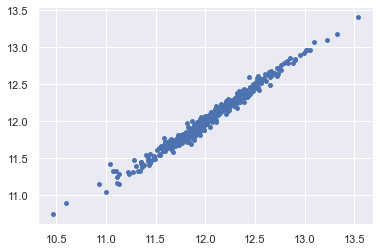

In [55]:
from sklearn.model_selection import train_test_split

rand_xtrain,rand_xtest,rand_ytrain,rand_ytest = train_test_split(xtrain,ytrain,test_size=0.3,random_state=42)

rand_ypred = best_model.predict(rand_xtest)

plt.scatter(rand_ytest,rand_ypred,s=15)

In [56]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(best_model,rand_xtest,rand_ytest,cv=kf,scoring=my_scorer)
score.mean()*(-1)

0.1473597699309484

### Make submit file

In [57]:
test['SalePrice']=np.exp(prediction)
test[['Id','SalePrice']].to_csv('submit.csv',index=False)

# trash code snippet below

In [58]:
asflj

NameError: name 'asflj' is not defined

In [ ]:
data.shape

In [ ]:
data.columns

1. norminal all drop
2. ordinal self-mapping


In [ ]:
new = pd.concat([data[imp_numeric_cols],data[imp_ordinal_cols]],axis=1)

xtrain = new.iloc[:split_point].copy()
xtest = new.iloc[split_point:].copy()
print(xtrain.shape)
print(xtest.shape)

ytrain = train['SalePrice'].map(np.log).copy()
ytrain.shape

best_model = RandomForestRegressor(n_estimators=500,max_features='sqrt')
best_model.fit(xtrain,ytrain)
prediction = best_model.predict(xtest)

rand_xtrain,rand_xtest,rand_ytrain,rand_ytest = train_test_split(xtrain,ytrain,test_size=0.3,random_state=42)
rand_ypred = best_model.predict(rand_xtest)
plt.scatter(rand_ytest,rand_ypred,s=15)

score = cross_val_score(best_model,rand_xtest,rand_ytest,cv=kf,scoring=my_scorer)
score.mean()*(-1)

In [ ]:
best_model = RandomForestRegressor(n_estimators=1000,max_features=50,max_depth=30)
best_model.fit(xtrain,ytrain)
prediction = best_model.predict(xtest)

rand_xtrain,rand_xtest,rand_ytrain,rand_ytest = train_test_split(xtrain,ytrain,test_size=0.3,random_state=42)
rand_ypred = best_model.predict(rand_xtest)
plt.scatter(rand_ytest,rand_ypred,s=15)

score = cross_val_score(best_model,rand_xtest,rand_ytest,cv=kf,scoring=my_scorer)
score.mean()*(-1)